In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import copy

import numpy as np
import matplotlib.pyplot as plt

from curv_scoring import get_curv_scores_for_net
from utils import full_train

In [2]:
class SubsetTransformDataset(Dataset):
    def __init__(self, dataset, subset_indices, subset_transform=None, default_transform=None):
        """
        Args:
            dataset (Dataset): The original dataset.
            subset_indices (list or range): The indices for the subset to apply the transform.
            subset_transform (callable, optional): A function/transform to apply to the subset.
            default_transform (callable, optional): A function/transform to apply to the entire datset first.
        """
        self.dataset = dataset
        self.subset_indices = subset_indices
        self.subset_transform = subset_transform
        self.default_transform = default_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.default_transform:
            image = self.default_transform(image)

        # Apply the transform only to the subset
        if idx in self.subset_indices and self.subset_transform:
            image = self.subset_transform(image)

        return image, label


In [3]:
class ReplaceWithDataset: # Transform
    def __init__(self, replace_dataset):
        """
        Args:
            replace_dataset (Dataset): The dataset to pick images from.
        """
        self.replace_dataset = replace_dataset

    def __call__(self, img):
        """
        Replace the given image with an image from replacement dataset.
        """
        # Randomly pick an index from the replacement dataset
        img, _ = self.replace_dataset[np.random.randint(0, len(self.replace_dataset))]
        
        # Resize if necessary (FashionMNIST is 28x28, make sure EMNIST image matches)
        if img.shape[1] != 28 or img.shape[2] != 28:
            img = transforms.Resize((28, 28))(img)

        return img

In [4]:
def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: Image
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        # print("Using GPU")
        image = image.cuda()
        net = net.cuda()


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    # fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            x.grad.zero_()

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    pert_image = pert_image.reshape(image.shape)
    
    return pert_image

In [5]:
class Deepfool:
    def __init__(self, net, overshoot=0.02):
        """
        Args:
            net: the net trained on original dataset
            overshoot: The amount of overshoot in deepfool attack
        """
        self.net = net
        self.overshoot = overshoot

    def __call__(self, img):
        """
        Replace the given image with a perturbed image per deepfool attack.
        """
        img = deepfool(img, self.net).cpu()

        return img

In [6]:
fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())

In [7]:
kmnist = torchvision.datasets.KMNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())

In [65]:
k_fashion = SubsetTransformDataset(fashion, torch.arange(1000), subset_transform=ReplaceWithDataset(kmnist))

In [66]:
def plot_idx(dset, idx):
    img, label = dset[idx]
    img_np = img.squeeze().numpy()
    plt.imshow(img_np, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

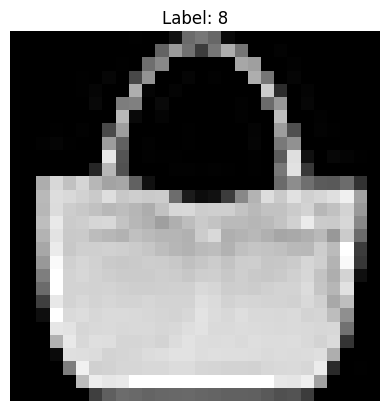

In [72]:
plot_idx(fashion, 100)

In [15]:
for i in range(10):
    print(f'Saving scores for run {i+1}...')
    subset_idx = torch.randperm(len(fashion))[:500].numpy()
    random_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx, subset_transform=ReplaceWithDataset(kmnist))
    net = full_train(random_dset)
    scores = get_curv_scores_for_net(random_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/random_500/run_{i+1}', **score_dict)


Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Saving scores for run 6...
Saving scores for run 7...
Saving scores for run 8...
Saving scores for run 9...
Saving scores for run 10...


In [8]:
basenet = full_train(fashion)

In [11]:
for i in range(100):
    if (i % 10) == 0:
        print(f'Saving scores for run {i+1}...')
    subset_idx = torch.randperm(len(fashion))[:100].numpy()
    random_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx, subset_transform=Deepfool(basenet))
    net = full_train(random_dset)
    scores = get_curv_scores_for_net(random_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/deepfool_100_overshoot_02/run_{i+1}', **score_dict)

Saving scores for run 1...
Saving scores for run 11...
Saving scores for run 21...
Saving scores for run 31...
Saving scores for run 41...
Saving scores for run 51...
Saving scores for run 61...
Saving scores for run 71...
Saving scores for run 81...
Saving scores for run 91...


In [16]:
for i in range(10):
    print(f'Saving scores for run {i+1}...')
    subset_idx = torch.randperm(len(fashion))[:500].numpy()
    random_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx, subset_transform=Deepfool(basenet))
    net = full_train(random_dset)
    scores = get_curv_scores_for_net(random_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/deepfool_500_overshoot_02/run_{i+1}', **score_dict)

Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Saving scores for run 6...
Saving scores for run 7...
Saving scores for run 8...
Saving scores for run 9...
Saving scores for run 10...


In [9]:
def get_boundary_scores_for_net(train, net):
    total = 0
    scores = torch.zeros(len(train))
    loader = torch.utils.data.DataLoader(dataset=train, batch_size=512, shuffle=False)
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs, targets = inputs.to('cuda'), targets.to('cuda')

            start_idx = total
            stop_idx = total + len(targets)
            idxs = [j for j in range(start_idx, stop_idx)]
            total = stop_idx

            logits = net(inputs)
            softmax_probs = F.softmax(logits, dim=1)
            max_softmax, _ = torch.max(softmax_probs, dim=1)
            
            scores[idxs] = max_softmax.cpu()

    return scores

In [10]:
boundary = get_boundary_scores_for_net(fashion, basenet)

(array([   57.,   428.,  1061.,  2170.,  3018.,  3016.,  3361.,  4165.,
         6170., 36554.]),
 array([0.1989146 , 0.27902314, 0.35913169, 0.43924022, 0.51934874,
        0.59945726, 0.67956585, 0.75967437, 0.83978289, 0.91989142,
        1.        ]),
 <BarContainer object of 10 artists>)

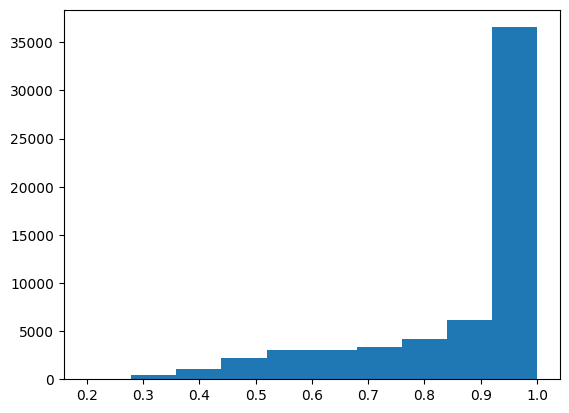

In [13]:
plt.hist(boundary)

In [17]:
_, indices = torch.topk(boundary, k=10, largest=False)
indices.numpy()

array([10541, 47678, 59429, 37709, 15233, 57122, 36468, 23045, 29603,
       44428])

In [10]:
for i in range(10):
    print(f'Saving scores for run {i+1}...')
    basenet = full_train(fashion)
    _, subset_idx = torch.topk(get_boundary_scores_for_net(fashion, basenet), k=10, largest=False)
    random_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx, subset_transform=ReplaceWithDataset(kmnist))
    net = full_train(random_dset)
    scores = get_curv_scores_for_net(random_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/random_10_attack/run_{i+1}', **score_dict)
    fool_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx)
    net = full_train(fool_dset)
    scores = get_curv_scores_for_net(fool_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/deepfool_10_overshoot_02_attack/run_{i+1}', **score_dict)

Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Saving scores for run 6...
Saving scores for run 7...
Saving scores for run 8...
Saving scores for run 9...
Saving scores for run 10...


In [11]:
for i in range(10):
    print(f'Saving scores for run {i+1}...')
    basenet = full_train(fashion)
    _, subset_idx = torch.topk(get_boundary_scores_for_net(fashion, basenet), k=100, largest=False)
    random_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx, subset_transform=ReplaceWithDataset(kmnist))
    net = full_train(random_dset)
    scores = get_curv_scores_for_net(random_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/random_100_attack/run_{i+1}', **score_dict)
    fool_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx)
    net = full_train(fool_dset)
    scores = get_curv_scores_for_net(fool_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/deepfool_100_overshoot_02_attack/run_{i+1}', **score_dict)

Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Saving scores for run 6...
Saving scores for run 7...
Saving scores for run 8...
Saving scores for run 9...
Saving scores for run 10...


In [12]:
for i in range(10):
    print(f'Saving scores for run {i+1}...')
    basenet = full_train(fashion)
    _, subset_idx = torch.topk(get_boundary_scores_for_net(fashion, basenet), k=1000, largest=False)
    random_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx, subset_transform=ReplaceWithDataset(kmnist))
    net = full_train(random_dset)
    scores = get_curv_scores_for_net(random_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/random_1000_attack/run_{i+1}', **score_dict)
    fool_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx)
    net = full_train(fool_dset)
    scores = get_curv_scores_for_net(fool_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/deepfool_1000_overshoot_02_attack/run_{i+1}', **score_dict)

Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Saving scores for run 6...
Saving scores for run 7...
Saving scores for run 8...
Saving scores for run 9...
Saving scores for run 10...


In [14]:
for i in range(10):
    print(f'Saving scores for run {i+1}...')
    basenet = full_train(fashion)
    _, subset_idx = torch.topk(get_boundary_scores_for_net(fashion, basenet), k=500, largest=False)
    random_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx, subset_transform=ReplaceWithDataset(kmnist))
    net = full_train(random_dset)
    scores = get_curv_scores_for_net(random_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/random_500_attack/run_{i+1}', **score_dict)
    fool_dset = SubsetTransformDataset(fashion, subset_indices=subset_idx)
    net = full_train(fool_dset)
    scores = get_curv_scores_for_net(fool_dset, net).cpu().numpy()
    score_dict = dict(subset=subset_idx, scores=scores)
    np.savez(f'curv_scores/deepfool_500_overshoot_02_attack/run_{i+1}', **score_dict)

Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Saving scores for run 6...
Saving scores for run 7...
Saving scores for run 8...
Saving scores for run 9...
Saving scores for run 10...


In [16]:
for i in range(10):
    print(f'Saving scores for run {i+1}...')
    basenet = full_train(fashion)
    scores = get_curv_scores_for_net(random_dset, basenet).cpu().numpy()
    score_dict = dict(subset=np.array([]), scores=scores)
    np.savez(f'curv_scores/base/run_{i+1}', **score_dict)

Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Saving scores for run 6...
Saving scores for run 7...
Saving scores for run 8...
Saving scores for run 9...
Saving scores for run 10...
